#Part I: Sentiment analysis

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

#Natural Language Toolkit
import nltk
from nltk.corpus import stopwords

In [2]:
import json

with open('small.omtm.usa.json') as infile:
    tweet_json = json.load(infile)

tweet_dict = {}

#initialize columns
for k in tweet_json[0].keys():
    tweet_dict[k] = []

#fill columns
for l in tweet_json:
    for tup in l.items():
        tweet_dict[tup[0]].append(tup[1])

In [3]:
nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /Users/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
#Convert to DF
tweet_df = pd.DataFrame(tweet_dict)

#Load in the dataframe of word-happiness rankings
sent_df = pd.DataFrame.from_csv('Data_Set_S1.txt', sep='\t', index_col=None)

#Load in stopwords
cachedStopWords = stopwords.words("english")

Let's prepare some regular expressions to handle abbreviations that people sometimes extend for emphasis like 'lollllll' or 'lmaoooo' or 'hahaha'. (Haven't finished this yet).

In [5]:
import re

#lollll -> lol. lmaoooooo -> lmao.
emph_stem = lambda s: re.sub(r'((\w)\2{2,})','\\2', s)

#this has it's own happiness rating
lolol = lambda s: re.sub(r'lolol(ol)*', 'lolol', s)

#(all three of these appear separately in the word positivity list)
haha = lambda s: re.sub(r'[a|h]{3,4}','haha', s)
hahaha = lambda s: re.sub(r'[a|h]{5,6}','hahaha', s)
hahahaha = lambda s: re.sub(r'[a|h]{7,140}','hahahaha', s)

def apply_re(word):
    if lolol(word) != word:
        return lolol(word)
    elif haha(word) != word:
        return haha(word)
    elif hahaha(word) != word:
        return hahaha(word)
    elif hahahaha(word) != word:
        return hahahaha(word)
    elif emph_stem(word) != word:
        return emph_stem(word)
    return word

##Let's create some functions to get simple happiness metrics for each tweet.

Here's one that takes in raw tweet text, removes stopwords and punctuation (this includes emoticons, but maybe it shouldn't), and returns the tweet as a list of words.

In [6]:
def tweet_to_list(tweet):
    
    tweet_list = nltk.tokenize.word_tokenize(tweet)
    tweet_list = [word.lower() for word in tweet_list if word.isalpha()]
    
    cachedStopWords.append('https')
    tweet_list = [word for word in tweet_list if word not in cachedStopWords]
    tweet_list = [apply_re(word) for word in tweet_list]
    
    return tweet_list

The function avg_happiness takes in the list of words in a tweet, obtains the frequency distribution of each word, then calculates a weighted average "happiness" score based on each word's happiness rating (from Data_Set_S1).

In [7]:
def avg_happiness(text_list):
    freqdist = nltk.FreqDist(text_list).items()
    
    happ_sum = 0
    count = 0
    
    for i in freqdist:
        word_row = sent_df[sent_df.word == i[0]]
        happ_score = word_row.happiness_average.values
        for i in happ_score:
            happ_sum += int(i)
            count += 1
            
    if count == 0:
        return None
    
    return float(happ_sum)/count

Now create a new row in tweet_df with happiness scores for each tweet. Note that with only around 35,000 tweets, the following takes ~30 minutes to run. This means that we probably shouldn't use all of the million+ tweets we're collecting — rather, we should probably try to sample a reasonable, equal number of tweets from each state in the hopes of obtaining balanced representation (i.e., excluding some tweets from the more twitter-heavy states once we have enough overall).

In [8]:
%time
happiness_score = lambda tweet: avg_happiness(tweet_to_list(tweet))
tweet_df['happ_scores'] = pd.Series(tweet_df.ttext_cleand.apply(happiness_score))

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 3.81 µs


In [9]:
#remove tweets with NaN happiness scores
tweet_df.dropna(inplace=True)

Now let us check what we got regarding state information. 

In [10]:
tweet_df['state'] = map(lambda x: x.upper(), tweet_df['state'])
tweet_df['state'].str.lstrip(')').str.rstrip('"').str.rstrip('-').str.rstrip('`')
pd.unique(tweet_df.state.ravel())

array([u'WA', u'CA', u'FL', u'IN', u'NJ', u'TX', u'NE', u'WI', u'NY',
       u'DC', u'AL', u'RI', u'IA', u'CALIFORNIA', u'MI', u'VIRGINIA',
       u'IL', u'ARKANSAS', u'AZ', u'OKLAHOMA', u'MA', u'MD', u'OH', u'GA',
       u'TENNESSEE', u'ME', u'GEORGIA', u'NM', u'TES', u'VA', u'OR', u'CO',
       u'CT', u'OREGON', u'TN', u'TAN', u'AR', u'MARYLAND', u'PA', u'MN',
       u'FLORIDA', u'SC', u'CONNECTICUT', u'MICHIGAN', u'NC', u'TEXAS',
       u'INDIANA', u'MO', u'KENTUCKY', u'KY', u'MS', u'LA', u'OHIO',
       u'WASHINGTON', u'WV', u'COLORADO', u'DOS', u'NORTH CAROLINA', u'NV',
       u'ALABAMA', u'OK', u'ID', u'IOWA', u'WISCONSIN', u'SOUTH CAROLINA',
       u'ILLINOIS', u'UT', u'NEW YORK', u'NEBRASKA', u'WEST VIRGINIA',
       u'PENNSYLVANIA', u'MAINE', u'MT', u'SOUTH DAKOTA', u'HI',
       u'RHODE ISLAND', u'SD', u'LOUISIANA', u'TLE', u'AK', u'VT',
       u'MISSOURI', u'MASSACHUSETTS', u'ARIZONA', u'NH', u'PRE', u'LUB',
       u'DE', u'NEW JERSEY', u'KS', u'DELAWARE', u'WAY', u'ONS', u'

Some data cleaning

In [21]:
tweet_df.state = tweet_df.state.replace(['CALIFORNIA','CALIF\xd3RNIA','CALIF\xd3RNIA'], 'CA')
tweet_df.state = tweet_df.state.replace(['VIRGINIA'], 'VA')
tweet_df.state = tweet_df.state.replace(['ARKANSAS'], 'AR')
tweet_df.state = tweet_df.state.replace(['OKLAHOMA'], 'OK')
tweet_df.state = tweet_df.state.replace(['GEORGIA'], 'GA')
tweet_df.state = tweet_df.state.replace(['TENNESSEE'], 'TN')
tweet_df.state = tweet_df.state.replace(['OREGON','OREG\xd3N'], 'OR')
tweet_df.state = tweet_df.state.replace(['MARYLAND'], 'MD')
tweet_df.state = tweet_df.state.replace(['FLORIDA'], 'FL')
tweet_df.state = tweet_df.state.replace(['CONNECTICUT'], 'CT')
tweet_df.state = tweet_df.state.replace(['MICHIGAN'], 'MI')
tweet_df.state = tweet_df.state.replace(['TEXAS'], 'TX')
tweet_df.state = tweet_df.state.replace(['INDIANA'], 'IN')
tweet_df.state = tweet_df.state.replace(['KENTUCKY'], 'KY')
tweet_df.state = tweet_df.state.replace(['OHIO'], 'OH')
tweet_df.state = tweet_df.state.replace(['WASHINGTON'], 'WA')
tweet_df.state = tweet_df.state.replace(['COLORADO'], 'CO')
tweet_df.state = tweet_df.state.replace(['NORTH CAROLINA'], 'NC')
tweet_df.state = tweet_df.state.replace(['ALABAMA'], 'AL')
tweet_df.state = tweet_df.state.replace(['IOWA'], 'IA')
tweet_df.state = tweet_df.state.replace(['WISCONSIN'], 'WI')
tweet_df.state = tweet_df.state.replace(['SOUTH CAROLINA'], 'SC')
tweet_df.state = tweet_df.state.replace(['ILLINOIS'], 'IL')
tweet_df.state = tweet_df.state.replace(['NEW YORK', 'NUEVA YORK'], 'NY')
tweet_df.state = tweet_df.state.replace(['NEBRASKA'], 'NE')
tweet_df.state = tweet_df.state.replace(['PENNSYLVANIA', 'PENSILVANIA', 'PENSILV\xc2NIA'], 'PA')
tweet_df.state = tweet_df.state.replace(['WEST VIRGINIA'], 'WV')
tweet_df.state = tweet_df.state.replace(['SOUTH DAKOTA'], 'SD')
tweet_df.state = tweet_df.state.replace(['MAINE','MAINA'], 'ME')
tweet_df.state = tweet_df.state.replace(['RHODE ISLAND'], 'RI')
tweet_df.state = tweet_df.state.replace(['LOUISIANA'], 'LA')
tweet_df.state = tweet_df.state.replace(['MISSOURI'], 'MO')
tweet_df.state = tweet_df.state.replace(['MASSACHUSETTS'], 'MA')
tweet_df.state = tweet_df.state.replace(['ARIZONA'], 'AZ')
tweet_df.state = tweet_df.state.replace(['NEW JERSEY'], 'NJ')
tweet_df.state = tweet_df.state.replace(['DELAWARE'], 'DE')
tweet_df.state = tweet_df.state.replace(['NEW HAMPSHIRE'], 'NH')
tweet_df.state = tweet_df.state.replace(['KANSAS'], 'KS')
tweet_df.state = tweet_df.state.replace(['UTAH'], 'UT')
tweet_df.state = tweet_df.state.replace(['MISSISSIPPI'], 'MS')
tweet_df.state = tweet_df.state.replace(['MONTANA'], 'MT')
tweet_df.state = tweet_df.state.replace(['NORTH DAKOTA'], 'ND')
tweet_df.state = tweet_df.state.replace(['WYOMING'], 'WY')
tweet_df.state = tweet_df.state.replace(['NEVADA'], 'NV')
tweet_df.state = tweet_df.state.replace(['MINNESOTA'], 'MN')
tweet_df.state = tweet_df.state.replace(['HAWAII'], 'HI')
tweet_df.state = tweet_df.state.replace(['LUISIANA'], 'LA')
tweet_df.state = tweet_df.state.replace(['PUERTO RICO'], 'PR')
tweet_df.state = tweet_df.state.replace(['NEW MEXICO','NUEVO M\xc9XICO'], 'NM')
tweet_df.state = tweet_df.state.replace(['VERMONT'], 'VT')
tweet_df.state = tweet_df.state.replace(['ALASKA'], 'AK')
tweet_df.state = tweet_df.state.replace(['DISTRICT OF COLUMBIA'], 'DC')

/Users/user/anaconda/lib/python2.7/site-packages/pandas/core/common.py:523: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  mask |= arr == x


In [22]:
tweet_df.head()

,coords,country,lang,place,state,timestamp,ttext,ttext_cleand,tweetid,userid,happ_scores,bool_happ
0,"47.614937999999995,-122.3306025",United States,en,"Seattle, WA",WA,1447266708839,"After taking public transit in DC and Seattle,...","after taking public transit in dc and seattle,...",664510856407834624,537328079,5.222222,True
1,"37.7050435,-122.162294",United States,en,"San Leandro, CA",CA,1447266710015,"Thankful for all the veterans out there, I lov...","thankful for all the veterans out there, i lov...",664510861340340228,3896359752,6.666667,True
2,"37.7706565,-122.4359785",United States,en,"San Francisco, CA",CA,1447266716814,"@Priz I've been watching, but not really enjoy...","AT_USER i've been watching, but not really enj...",664510889857433600,15532647,5.714286,True
3,"26.270260999999998,-80.2497725",United States,en,"Coral Springs, FL",FL,1447266717060,@awolnation it's my bday too 💕,AT_USER it's my bday too 💕,664510890889342976,1064780006,7.000000,True
4,"39.7795625,-86.1429225",United States,en,"Indianapolis, IN",IN,1447266716818,@bobandtom VIP cam has been running over 7 hou...,AT_USER vip cam has been running over 7 hours!...,664510889874186240,63448519,5.200000,True


In [23]:
state_avg_happ = {}

for state in tweet_df.state.unique():
    try:
        int(state)
    except:
        if len(state) != 2:
            continue
        state_col = tweet_df[tweet_df.state==state].happ_scores
        state_avg = np.mean(state_col)
        state_avg_happ[state] = np.mean(state_avg)

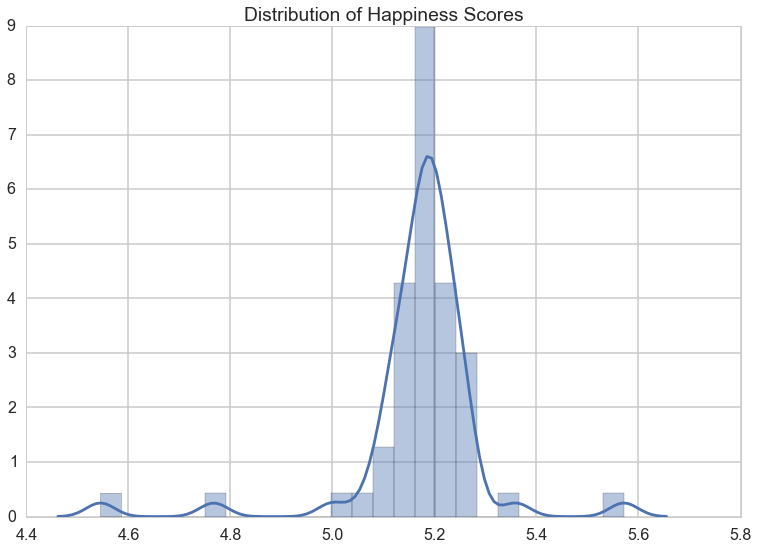

In [24]:
ax = sns.distplot(state_avg_happ.values())
ax.set_title('Distribution of Happiness Scores')

In [25]:
def norm(col):
    return (col - np.mean(col))/(max(col) - min(col))

tweet_df.norm_happ = norm(tweet_df.happ_scores)

#add boolean tweet positivity indicator
tweet_df['bool_happ'] = pd.Series(tweet_df.norm_happ > 0)

print 'Ratio positive tweets in New York: ' + str(np.mean(tweet_df[tweet_df.state=='NY'].bool_happ))
print 'Ratio positive tweets in Louisiana: ' + str(np.mean(tweet_df[tweet_df.state=='LA'].bool_happ))

Ratio positive tweets in New York: 0.472216072615
Ratio positive tweets in Louisiana: 0.395547945205


In [119]:
state_happ_ratio = {}

for state in tweet_df.state.unique():
    try:
        int(state)
    except:
        if len(state) != 2:
            continue
        state_bool = tweet_df[tweet_df.state==state].bool_happ
        state_avg_bool = np.mean(state_bool)
        state_happ_ratio[state] = np.mean(state_avg_bool)

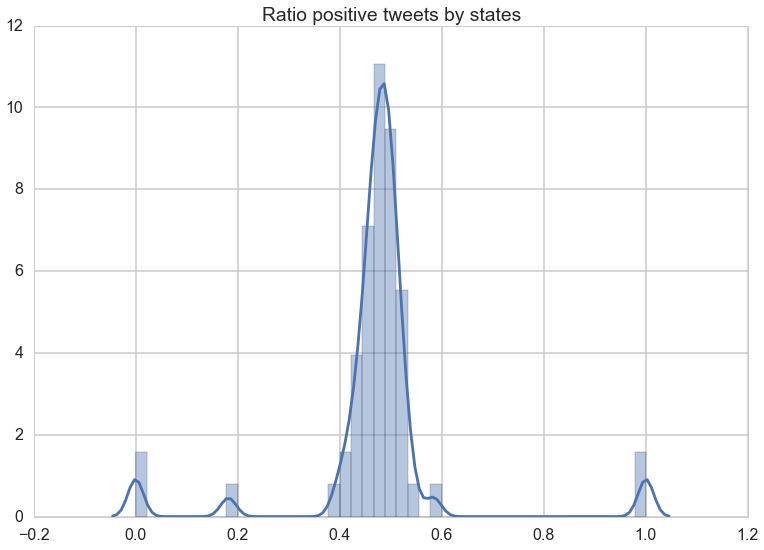

In [120]:
ax = sns.distplot(state_happ_ratio.values())
ax.set_title('Ratio positive tweets by states')

Now let's create a dictionary containing overall "happy" or "unhappy" labels for each state based on these ratios of happy to unhappy tweets. If a state's ratio falls above the overall ratio for the US, then than state is labelled happy. As you can see below, about 47% of US tweets are positive according to our simple sentiment analysis.

In [463]:
ybar = np.mean(tweet_df.bool_happ)
ybar

0.47163663543805923

In [122]:
state_happ_bool = {}

for k,v in state_happ_ratio.items():
    state_happ_bool[k] = v > ybar

##Happiness ranking for each US state

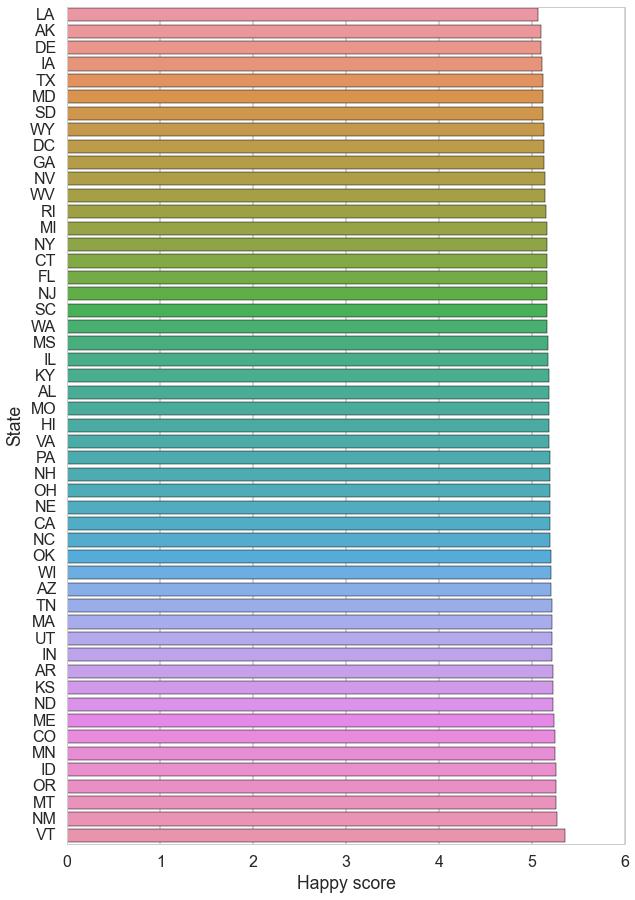

In [508]:
plt.figure(figsize=(10, 15))
happy_df_r = pd.DataFrame(state_avg_happ.items(), columns=['state', 'happyscore'])
happy_df_r = happy_df_r[happy_df_r.state != 'C1']
happy_df_r = happy_df_r[happy_df_r.state != 'DR']
happy_df_r = happy_df_r[happy_df_r.state != 'FU']
happy_df_r = happy_df_r[happy_df_r.state != 'HQ']
happy_df_r = happy_df_r[happy_df_r.state != 'XD']
happy_df_r = happy_df_r[happy_df_r.state != 'PR']
 

plot0=sns.barplot(x= "happyscore", y="state", data=happy_df_r.sort("happyscore"))
plot0.set_ylabel("State")
plot0.set_xlabel("Happy score")

In [509]:
tweet_df.to_csv('tweets_w_sent.csv', encoding='utf-8')

In [510]:
tweet_df.head()

,coords,country,lang,place,state,timestamp,ttext,ttext_cleand,tweetid,userid,happ_scores,bool_happ
0,"47.614937999999995,-122.3306025",United States,en,"Seattle, WA",WA,1447266708839,"After taking public transit in DC and Seattle,...","after taking public transit in dc and seattle,...",664510856407834624,537328079,5.222222,True
1,"37.7050435,-122.162294",United States,en,"San Leandro, CA",CA,1447266710015,"Thankful for all the veterans out there, I lov...","thankful for all the veterans out there, i lov...",664510861340340228,3896359752,6.666667,True
2,"37.7706565,-122.4359785",United States,en,"San Francisco, CA",CA,1447266716814,"@Priz I've been watching, but not really enjoy...","AT_USER i've been watching, but not really enj...",664510889857433600,15532647,5.714286,True
3,"26.270260999999998,-80.2497725",United States,en,"Coral Springs, FL",FL,1447266717060,@awolnation it's my bday too 💕,AT_USER it's my bday too 💕,664510890889342976,1064780006,7.000000,True
4,"39.7795625,-86.1429225",United States,en,"Indianapolis, IN",IN,1447266716818,@bobandtom VIP cam has been running over 7 hou...,AT_USER vip cam has been running over 7 hours!...,664510889874186240,63448519,5.200000,True


#Part II: The association of happiness with health? 

##Let's create the dataset.

The outcome is the happy score we created just now, along with the ratio of positive tweets for each state. 

In [511]:
#Outcome dataframe
happy_df = pd.DataFrame(state_avg_happ.items(), columns=['state', 'happyscore'])
happy_df = happy_df.set_index(['state'])
happy_df=happy_df.sort_index()
happy_df=happy_df.drop(['C1','DR','FU','HQ','XD','PR'])
happy_df=happy_df.sort_index()

happy_df_bool = pd.DataFrame(state_happ_bool.items(), columns=['state', 'happy_bool'])
happy_df_bool = happy_df_bool.set_index(['state'])
happy_df_bool=happy_df_bool.sort_index()
happy_df_bool=happy_df_bool.drop(['C1','DR','FU','HQ','XD','PR'])
happy_df_bool=happy_df_bool.sort_index()

happy = happy_df.join(happy_df_bool)
happy_s=happy['happyscore']

We obtained the health score for each state from the America's Health Rankings: State public health statistics (Annual report 2014) http://www.americashealthrankings.org/

In [512]:
#exposure dataframe
xlsx = pd.ExcelFile('health_cleaned.xlsx')
health = xlsx.parse(0)
health = health.set_index(['state'])
health=health.sort_index()

In [513]:
health_list=list(health.columns)
health_listn = []
for healthl in health_list:
    healthn=str(healthl)
    health_listn.append(healthn)

health_listn

['Air_Pollution',
 'All_Determinants',
 'Binge_Drinking',
 'Cancer_Death',
 'Cardiovascular_Death',
 'Children_in_Poverty',
 'Chlamydia',
 'Cholesterol_Check',
 'Colorectal_Cancer_Screening',
 'Dental_Visit_Annual',
 'Dentists',
 'Diabetes',
 'Disparity_in_Health_Status',
 'Drug_Death',
 'Excessive_Drinking',
 'Fruits',
 'Heart_Attack',
 'Heart_Disease',
 'High_Blood_Pressure',
 'High_Cholesterol',
 'High_Health_Status',
 'High_School_Graduation',
 'Immunization_Adolescents',
 'Immunization_Children',
 'Immunization_Dtap',
 'HPV',
 'Immunization_MCV4',
 'Income_Disparity',
 'Infant_Mortality',
 'Infectious_Disease',
 'Insufficient_Sleep',
 'Lack_of_Health_Insurance',
 'Low_Birthweight',
 'Median_Household_Income',
 'Obesity',
 'Youth_obesity',
 'Occupational_Fatalities',
 'Overall',
 'Personal_Income_Per_Capita',
 'Pertussis',
 'Physical_Activity',
 'Poor_Mental_Health_Days',
 'Poor_Physical_Health_Days',
 'Premature_Death',
 'Preterm_Birth',
 'Preventable_Hospitalizations',
 'Primary_

As we can see from the list above, the data frame includes 1) socio-economic status for each state; 2) environmental factor; 3) infectious disease; 4) mental health and substance abuse; 5) chronic diseases, such as; 6) dental health; 7) maternal and child health; 8) health disparity; 9) immunization status; 10) accidental and non-accidental death; and 11) overall health status.  

Merge the exposure and outcome dataset

In [514]:
Com_df=health.join(happy)

In [515]:
Com_df.head()

,Air_Pollution,All_Determinants,Binge_Drinking,Cancer_Death,Cardiovascular_Death,Children_in_Poverty,Chlamydia,Cholesterol_Check,Colorectal_Cancer_Screening,Dental_Visit_Annual,Dentists,Diabetes,Disparity_in_Health_Status,Drug_Death,Excessive_Drinking,Fruits,Heart_Attack,Heart_Disease,High_Blood_Pressure,High_Cholesterol,High_Health_Status,High_School_Graduation,Immunization_Adolescents,Immunization_Children,Immunization_Dtap,HPV,Immunization_MCV4,Income_Disparity,Infant_Mortality,Infectious_Disease,Insufficient_Sleep,Lack_of_Health_Insurance,Low_Birthweight,Median_Household_Income,Obesity,Youth_obesity,Occupational_Fatalities,Overall,Personal_Income_Per_Capita,Pertussis,Physical_Activity,Poor_Mental_Health_Days,Poor_Physical_Health_Days,Premature_Death,Preterm_Birth,Preventable_Hospitalizations,Primary_Care_Physicians,Public_Health_Funding,Salmonella,Smoking,Stroke,Suicide,Teen_Birth_Rate,Teeth_Extractions,Underemployment_Rate_value,Vegetables,Violent_Crime,Youth_Smoking,happyscore,happy_bool
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AK,4.9,-0.058,19.5,191.8,219.2,15.9,755.8,70.1,58.4,67.4,80.9,7.1,25.7,14.4,21.1,1.40,3.1,3.2,29.8,38.6,53.7,79,52.2,63.9,74.3,27.1,55.2,0.408,4.5,0.72,35.3,19.5,5.7,61137,28.4,12.4,6.1,0.125,50150,48.8,77.7,3.1,3.7,7600,9.2,46.7,113.2,218.51,8.1,22.6,2.2,23.2,34.5,3.9,12.1,2.03,603.2,10.6,5.096769,False
AL,10.0,-0.335,11.2,211.5,329.2,26.4,637.6,77.6,67.7,58.6,43.8,13.8,19.4,11.7,12.3,1.15,5.9,5.3,40.3,44.4,44.4,75,65.5,77.0,87.3,39.6,69.5,0.475,8.6,0.65,37.5,13.4,10.0,41381,32.4,17.1,5.3,-0.664,36481,4.4,68.5,4.4,4.9,10008,14.6,71.5,101.9,116.50,23.9,21.5,4.7,15.0,39.2,8.5,12.2,1.75,449.9,18.0,5.183851,False
AR,10.3,-0.655,12.5,214.9,313.7,23.8,565.4,72.3,58.4,54.9,41.7,11.5,24.2,12.6,13.7,1.21,5.1,5.3,38.7,42.4,42.7,78,47.5,57.1,77.7,24.4,40.4,0.469,7.2,0.90,36.1,16.2,8.7,39919,34.6,17.8,7.5,-0.934,36698,8.4,65.6,4.4,4.8,9656,13.3,71.6,102.6,98.62,47.8,25.9,4.5,16.7,45.7,9.1,13.7,1.78,469.1,19.1,5.227780,True
AZ,9.9,-0.008,13.4,170.2,216.1,27.2,469.6,72.6,60.5,61.6,55.0,10.7,36.6,17.7,14.8,1.36,4.4,4.1,30.7,39.7,52.8,77,69.5,65.1,84.4,37.4,86.7,0.468,5.9,-0.10,34.6,17.3,6.9,50602,26.8,10.7,3.2,-0.039,36983,17.5,74.8,3.9,4.4,7124,11.6,45.2,98.4,43.55,13.3,16.3,2.8,18.0,37.4,4.2,16.0,1.99,428.9,14.1,5.210010,True
CA,13.9,0.294,17.4,171.0,234.4,20.3,444.9,75.2,68.7,67.0,78.0,10.2,38.6,11.0,18.9,1.67,3.3,3.1,28.7,37.7,50.7,82,72.6,69.3,91.1,45.8,80.9,0.490,4.6,-0.40,33.7,17.5,6.7,57528,24.1,NaN,3.2,0.348,48434,2.1,78.6,3.8,3.9,5590,9.6,45.3,122.2,104.40,12.1,12.5,2.2,10.5,26.5,2.4,17.3,2.21,423.1,NaN,5.197678,True


##Let us look at the correlations of health and happiness first.
Considering we are more interested in the ranking of each state intead of the actual values for both health and happiness, we will use the Spearman's rank correlation.

###Let us check the overal health status and happiness first. 

In [516]:
sp.stats.stats.spearmanr(Com_df['Overall'], Com_df['happyscore'])

SpearmanrResult(correlation=0.2045295142947518, pvalue=0.14995467998872172)

Higher overall health is correlated with higher happy score, although the p value is not significant.

###Can money buy happiness? 

In [517]:
sp.stats.stats.spearmanr(Com_df['Personal_Income_Per_Capita'], Com_df['happyscore'])

SpearmanrResult(correlation=-0.22262443438914029, pvalue=0.11636407078401174)

In [518]:
sp.stats.stats.spearmanr(Com_df['Median_Household_Income'], Com_df['happyscore'])

SpearmanrResult(correlation=-0.047330316742081449, pvalue=0.74154246083799391)

Not really. We observed negative correlation coefficiencies with non significant values.

###Let us look at all the variables included in our exposure data frame.

In [519]:
rho =[]
corrdict= {}
for outcome in health_list:
    rho1 = sp.stats.stats.spearmanr(health [outcome], happy_s)[0]
    corrdict=dict(health=outcome, corr=rho1)
    
    rho.append(corrdict)

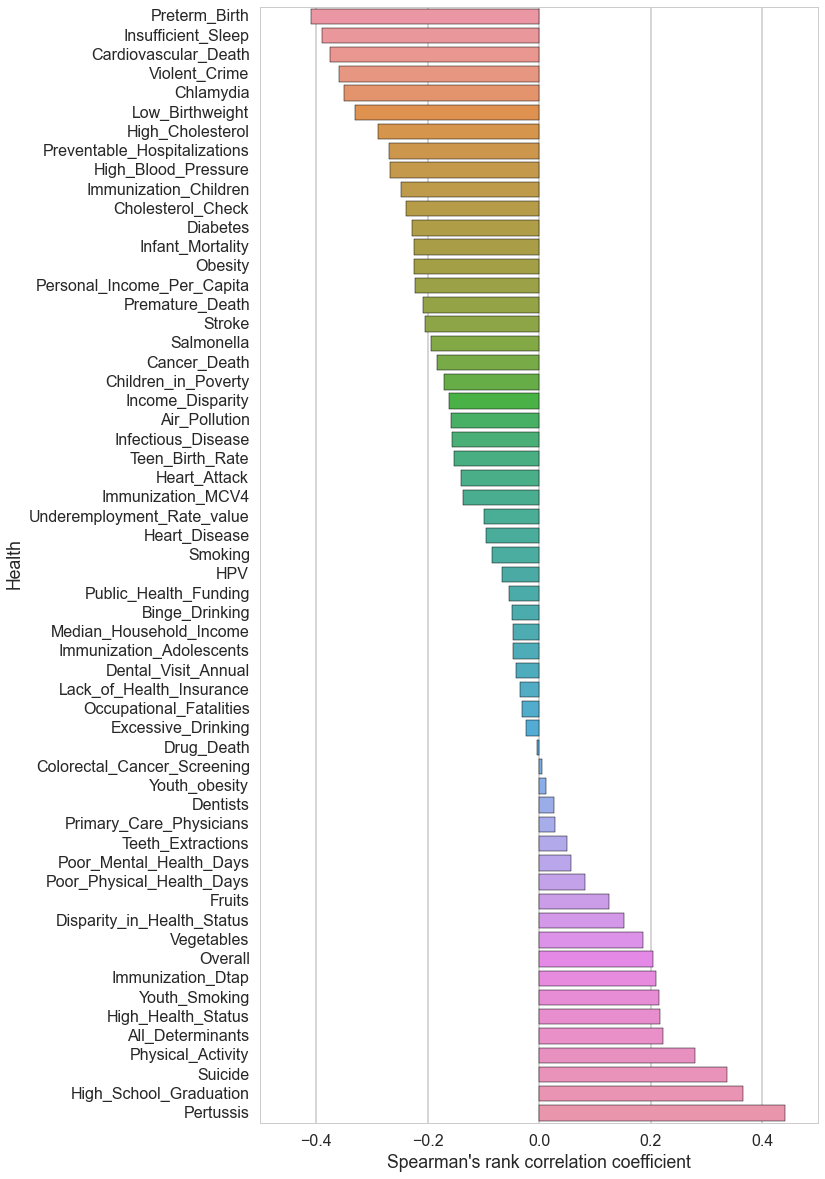

In [520]:
corr_df=pd.DataFrame(rho)

plt.figure(figsize=(10, 20))
plot1=sns.barplot(x="corr", y="health", data=corr_df.sort("corr"))
plot1.set_ylabel("Health")
plot1.set_xlabel("Spearman's rank correlation coefficient")

Some correlations make sense, some not. Such as suicide rate is positively correlated with higher happy score. We have to bear in mind some caveats when interpreting this analysis. We use aggregated data for each state (https://en.wikipedia.org/wiki/Ecological_fallacy). We do not consider any potential confounders. 


# What are the predictors for happy score we obtained from twitter?

##Check linearity

###This part is weird... Maybe we should just delete it. Any suggestions?

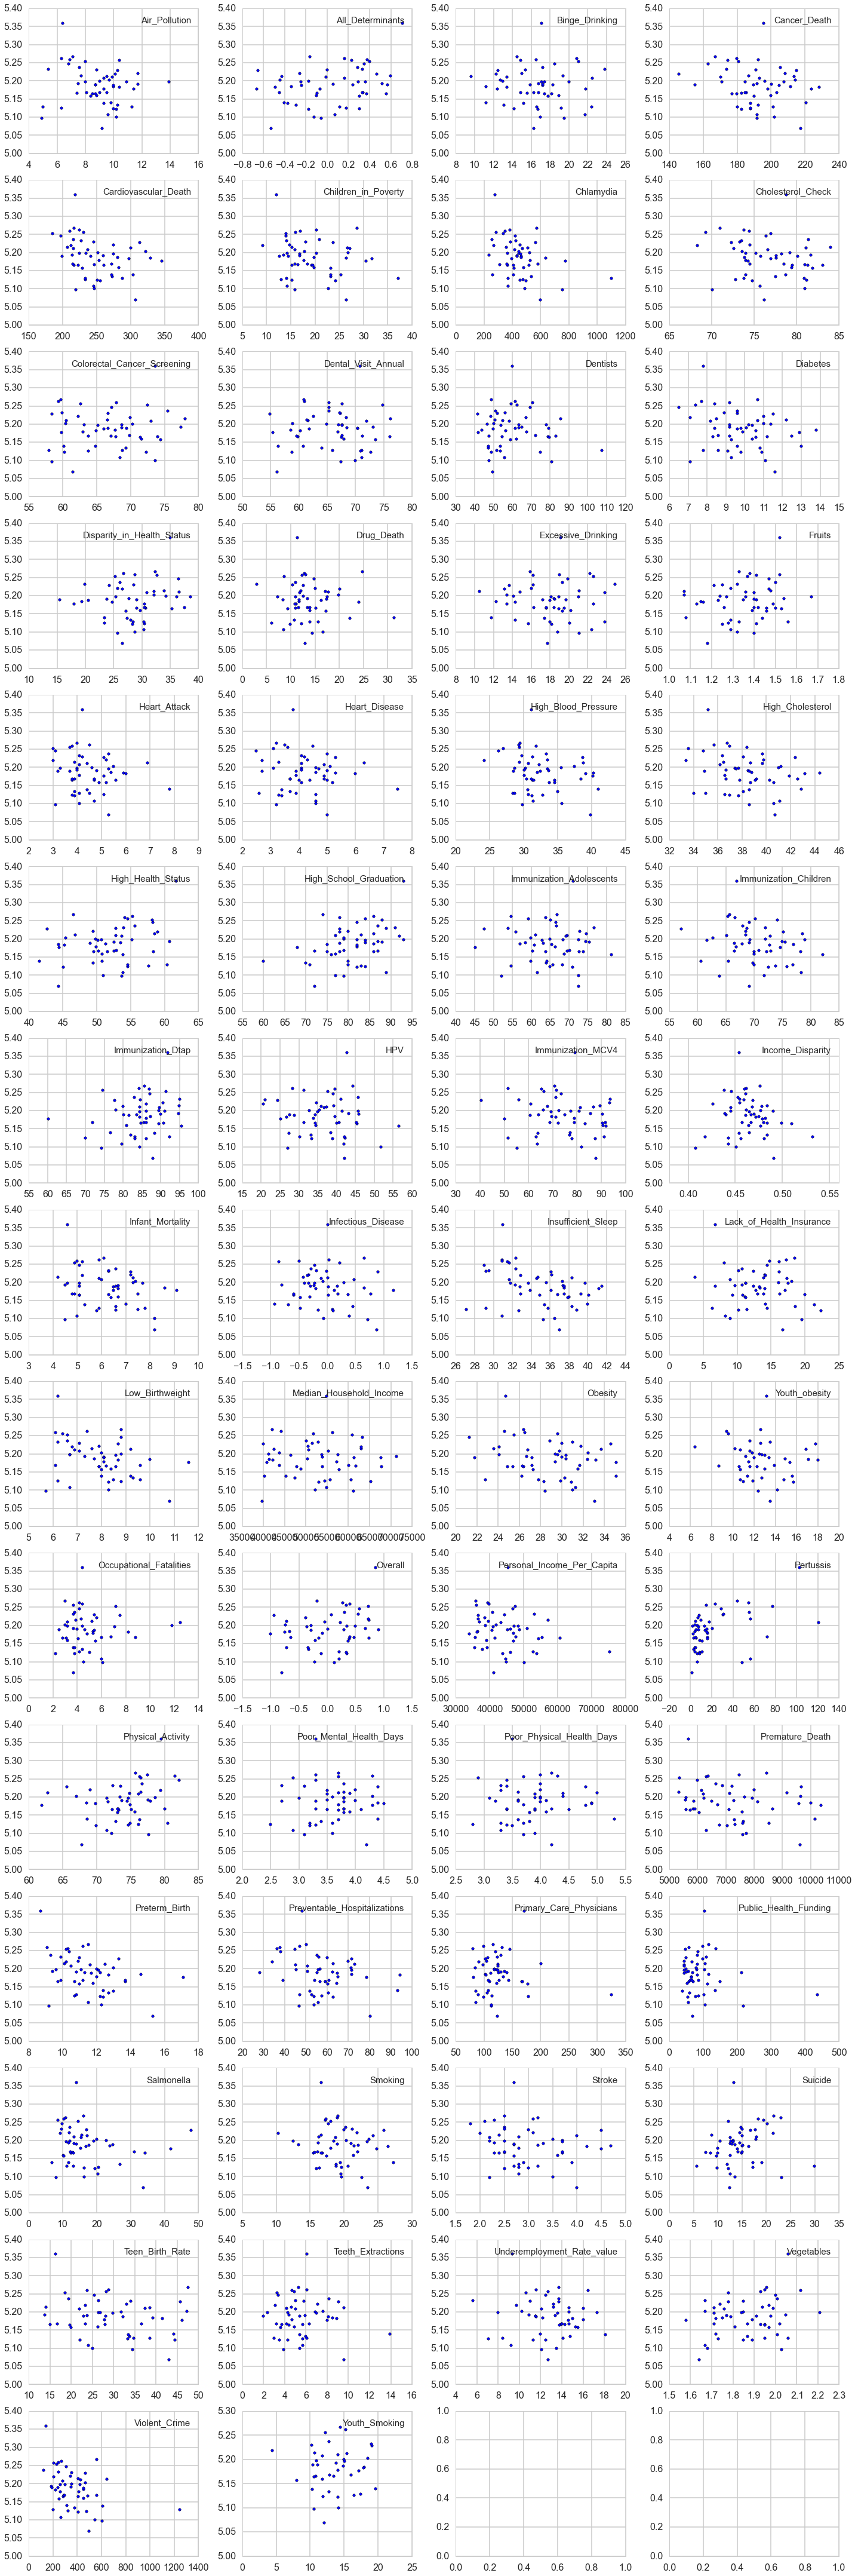

In [521]:
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
fig, axes = plt.subplots(nrows=15,ncols=4, figsize=(20,60), tight_layout=True)

Com_df=Com_df.sort_index()
Y=Com_df['happyscore']

for ax, lst in zip(axes.ravel(),health_listn):
    X=Com_df[lst] 
    ax.scatter(X, Y)
    ti=AnchoredText(lst, prop=dict(size=15), frameon=False,loc=1)
    ax.add_artist(ti)

###Interpreting these scatter plots

So it looks like on the whole none of these variables are strongly linearly correlated with state happiness score. However, a few variables seem to show slight negative correlations – for example, chlamydia, air pollution, and cardio vascular death. This is what we expected (and hoped to see), since it stands to reason that a state with higher rates of air pollution and heart attacks would be less happy as a result.

## Check collinearity

We notice that in the dataset, for example, we have Personal Income Per Capita and Median Household Income as indicators for income, which are expected to be highly correlated. We want to check colinearity before we throw all the variables into the model. 

###Correlation matrix

We got the absolute values for each correlation and list the highest correlation pairs. 

In [522]:
corr = health.corr ().abs()
corr
corr_s = corr.unstack()
corr_sort = corr_s.order(kind="quicksort",ascending=False)
pd.set_option('display.max_rows', 1000)
print corr_sort

Youth_Smoking                 Youth_Smoking                   1.000000
Infant_Mortality              Infant_Mortality                1.000000
Insufficient_Sleep            Insufficient_Sleep              1.000000
Lack_of_Health_Insurance      Lack_of_Health_Insurance        1.000000
Low_Birthweight               Low_Birthweight                 1.000000
Median_Household_Income       Median_Household_Income         1.000000
Obesity                       Obesity                         1.000000
Youth_obesity                 Youth_obesity                   1.000000
Occupational_Fatalities       Occupational_Fatalities         1.000000
Overall                       Overall                         1.000000
Personal_Income_Per_Capita    Personal_Income_Per_Capita      1.000000
Pertussis                     Pertussis                       1.000000
Physical_Activity             Physical_Activity               1.000000
Poor_Mental_Health_Days       Poor_Mental_Health_Days         1.000000
Poor_P

#### Get rid of those variables that are highly correlated

In [523]:
Com_df_full = Com_df

In [524]:
del Com_df['All_Determinants']
del Com_df['Premature_Death']
del Com_df['Immunization_MCV4']
del Com_df['Heart_Attack']
del Com_df['Cardiovascular_Death']
del Com_df['Stroke']
del Com_df['High_Cholesterol']
del Com_df['High_Blood_Pressure']
del Com_df['Diabetes']
del Com_df['High_Health_Status']
del Com_df['Low_Birthweight']
del Com_df['Binge_Drinking']
del Com_df['Teeth_Extractions']
del Com_df['Obesity']
del Com_df['Preventable_Hospitalizations'] 
del Com_df['Vegetables'] 
del Com_df['Personal_Income_Per_Capita'] 
del Com_df['Overall'] 
del Com_df['Cancer_Death'] 
del Com_df['Dental_Visit_Annual'] 
del Com_df['Income_Disparity'] 
del Com_df['Disparity_in_Health_Status']
del Com_df['Children_in_Poverty']
del Com_df ['Immunization_Dtap']
del Com_df['Underemployment_Rate_value']
del Com_df['Lack_of_Health_Insurance']
del Com_df ['Chlamydia']
del Com_df['Cholesterol_Check']
del Com_df['Median_Household_Income']
del Com_df['happy_bool']

#### Let's see what are left in the dataset.

In [525]:
print list(Com_df.columns)
print len(Com_df.columns)

[u'Air_Pollution', u'Colorectal_Cancer_Screening', u'Dentists', u'Drug_Death', u'Excessive_Drinking', u'Fruits', u'Heart_Disease', u'High_School_Graduation', u'Immunization_Adolescents', u'Immunization_Children', u'HPV', u'Infant_Mortality', u'Infectious_Disease', u'Insufficient_Sleep', u'Youth_obesity', u'Occupational_Fatalities', u'Pertussis', u'Physical_Activity', u'Poor_Mental_Health_Days', u'Poor_Physical_Health_Days', u'Preterm_Birth', u'Primary_Care_Physicians', u'Public_Health_Funding', u'Salmonella', u'Smoking', u'Suicide', u'Teen_Birth_Rate', u'Violent_Crime', u'Youth_Smoking', 'happyscore']
30


30 variables were left in the data frame.

Save Com_df_full for future reloading:

In [526]:
Com_df_full.to_csv('Com_df_full.csv')

In [505]:
#Reload from csv
#Com_df_full = pd.read_csv('Com_df_full.csv')

### Forward Selection (http://planspace.org/20150423-forward_selection_with_statsmodels/)
We will use forward select to optimize adjusted R-squared by adding features that help the most one at a time until the score goes down or run out of features.

In [527]:
import statsmodels.formula.api as smf

def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

In [528]:
model = forward_selected(Com_df, 'happyscore')

print model.model.formula
print model.rsquared_adj
print model.summary()

happyscore ~ Pertussis + Youth_obesity + Violent_Crime + Excessive_Drinking + High_School_Graduation + Heart_Disease + Poor_Physical_Health_Days + Insufficient_Sleep + Occupational_Fatalities + Primary_Care_Physicians + Immunization_Children + 1
0.613950309194
                            OLS Regression Results                            
Dep. Variable:             happyscore   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     6.928
Date:                Wed, 09 Dec 2015   Prob (F-statistic):           1.16e-05
Time:                        11:34:05   Log-Likelihood:                 90.875
No. Observations:                  42   AIC:                            -157.7
Df Residuals:                      30   BIC:                            -136.9
Df Model:                          11                                         
Covariance Type:            

From the 30 variables left in the data frame, forward selection helped us identify 11 predictions which optimized the R-square.  Of the 11 predictors, violence crime, excessive drinking, heart disease, poor physical health days, insufficient sleep, primary care physicians, and immunization status among children were significant. For example, holding other predictors constant, one unit increase in violent crime is associated with 0.0002 point lower happy score.  


##Implementing a Random Forest Classifier
If health data can allow us to predict whether or not a state is happy or unhappy relative to the mean level of happiness in the U.S., that suggests some sort of relationship exists between health and happiness. Let's see if it can, using a random forest classifier.

Why random forest, you ask? Well, our health data has a lot of features (60 in total), none of which seem to be significantly more useful than other features in generating predictions. The RF algorithm creates a forest of trees sampling from among all of these features for each tree -- hopefully, this sampling of features will include combinations of features that happen to be more significant than others, giving us a more accurate prediction.

The off-the-shelf RF classifier can't handle any NaN columns, so let's fill all NaN values with the mean value for that feature.

NOTE: This is the original Com_df, without any columns omitted.

In [529]:
Com_df_full = Com_df_full.apply(lambda x: x.fillna(x.mean()),axis=0)

In [453]:
from sklearn.cross_validation import train_test_split

train_df, test_df = train_test_split(Com_df, train_size=25)
Xtrain = train_df.drop(['happyscore','happy_bool'],axis=1)
ytrain = train_df['happy_bool']
Xtest = test_df.drop(['happyscore','happy_bool'],axis=1)
ytest = test_df['happy_bool']

So we're working with very, very little training data -- this is a product of the fact that we're reasoning about states, and there are only 50 in total.

Let's train a Random Forest with 100 trees to start off. Given how little data there is, we would be hard-pressed to create a cross-validation set in addition to our training and test sets, so we won't worry too much about whether this is the optimal number of trees (or whether other parameters like max depth are optimized).

In [454]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, max_depth=None)
clf.fit(Xtrain,ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [455]:
ypred = list(clf.predict(Xtest))
accuracy = sum(ypred == ytest)*1.0/len(ytest)
print 'accuracy: ' + str(accuracy)

accuracy: 0.461538461538


Ok, we shouldn't feel to inclined to trust that value, since we're testing (and training) on so little data. To get a better sense of whether an RF classifier offers us better-than-chance predictions of the relative happiness of a state, let's run the train-test split and fit the model 500 times to get a sense of the distribution of accuracies.

In [456]:
from sklearn.metrics import precision_score

%time

accuracies = []
prec_scores = []

for i in range(0,1000):
    #obtain train-test split
    train_df, test_df = train_test_split(Com_df, train_size=.6)
    train_df.dropna(inplace=True)
    test_df.dropna(inplace=True)
    Xtrain = train_df.drop(['happyscore','happy_bool'],axis=1)
    ytrain = train_df['happy_bool']
    Xtest = test_df.drop(['happyscore','happy_bool'],axis=1)
    ytest = test_df['happy_bool']

    #fit classifier
    clf = RandomForestClassifier(n_estimators=150)
    clf.fit(Xtrain,ytrain)
    
    #calculate accuracy
    ypred = list(clf.predict(Xtest))
    accuracy = sum(ypred == ytest)*1.0/len(ytest)
    accuracies.append(accuracy)
    prec_scores.append(precision_score(ytest, ypred))
    
mean_acc = np.mean(accuracies)
print 'mean accuracy: ' + str(mean_acc)

/Users/user/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/user/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 4.05 µs
mean accuracy: 0.608476190476


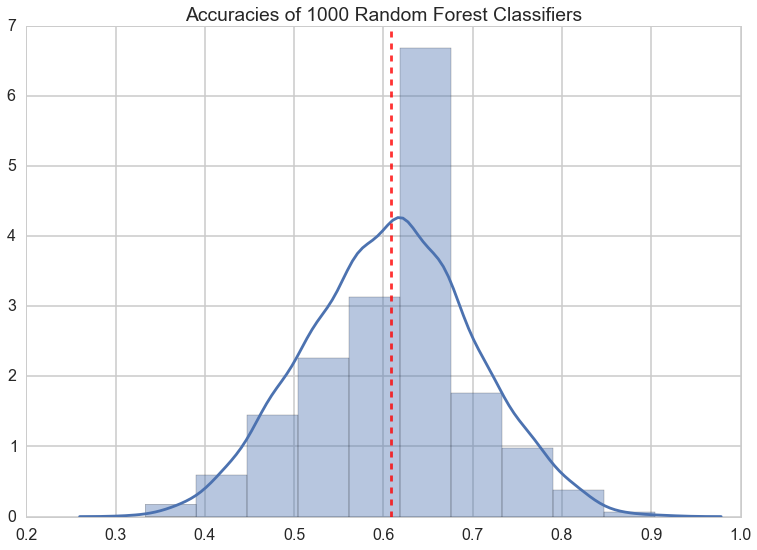

In [457]:
mean_acc = np.mean(accuracies)
ax = sns.distplot(accuracies, bins=10)
ax.axvline(mean_acc, linestyle='--', color='red', alpha=.8)
ax.set_title('Accuracies of 1000 Random Forest Classifiers')

Our distribution of accuracies is approximately normal, with a very wide range (from around .35 to .8) and mean around .6. If our goal was to build an accurate predictive model from our data, the high variability in accuracy we see here might be disheartening, but this is not our goal. Instead, we set out to see whether there was some relationship between the healthiness and happiness of a given state. Does this result suggest that there is?

Answering this question takes a bit more thought. Since 60% of states are labelled happy, we would see 60% accuracy in our model if we just guessed that all states were happy. Well, our RF classifier on average does no better than that, by a simple, percentage-based accuracy measure. But this doesn't outright suggest our model is useless. Let's consider another, more subtle measure of the strength of a model, the precision score, which takes into account both the true positives and false positives of the model.

The precision score of the all-true strategy can be calculated as follows:
$$Precision = \frac{tp}{tp + fp} = \frac{30}{50} = .60$$

Let's see the distribution of precision for our RF model:

mean precision: 0.657112216735


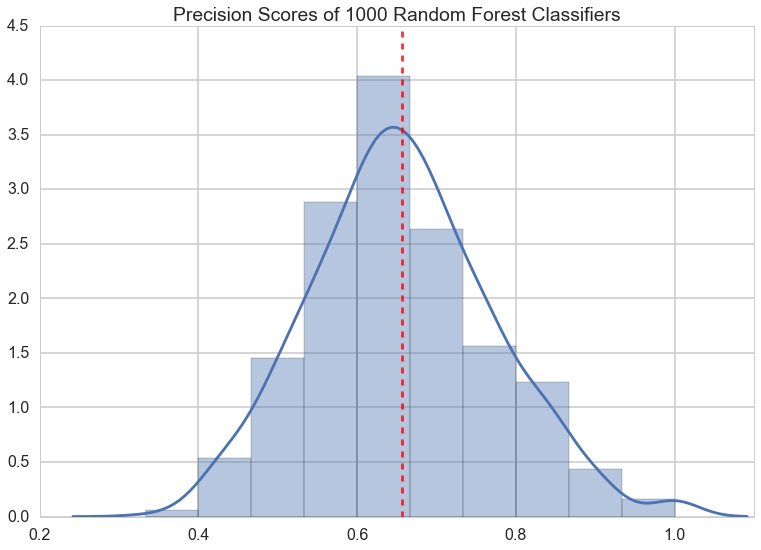

In [459]:
pbar = np.mean(prec_scores)

ax = sns.distplot(prec_scores, bins=10)
ax.axvline(pbar, linestyle='--', color='red', alpha=.8)
ax.set_title('Precision Scores of 1000 Random Forest Classifiers')

print "mean precision: " + str(pbar)

So the precision score of our RF classifier is around .06 better than the all-true baseline -- this is a reasonably large margin. Assuming that our happiness labels are valid indicators of a state's relative happiness, this result suggests that public health-related statistics can in fact help predict happiness. So, we can confidently say that *some* relationship exists between the health data and the twitter sentiment data. Perhaps the relationship is attributable to confounding variables, but for now, we can answer our overarching question with "Plausibly Yes". 